In [1]:
import pandas as pd
import numpy as np
import math
from collections import defaultdict
import ts_code.nsfg as nsfg
import ts_code.thinkstats2 as thinkstats2
import ts_code.thinkplot as thinkplot
import ts_code.first as first
import matplotlib.pyplot as plt
import ts_code.brfss as brfss
%matplotlib inline

## Chapter 10 - Linear least squares

Correlation coefficients only measure the strenth and sign of a relationship, not the slope. The most common way to do this is **linear least squares fit**. This is a linear fit that minimizes the mean squared error (MSE) between the line and the data.

As long as a correlation isn't perfect, the prediction line is only approximate. The vertical deviation from the line is called a **residual** and is expressed as;

$r = y - (mx + b)$, where $x$ and $y$ are sequences of points, $m$ is the slope and $b$ is the intercept.

What we want to minimize is the *sum of the squared residuals* and there are a few good reasons for this;

+ Squaring has the feature of treating positive and negative residuals the same.

+ Squaring gives more weight to large residuals, but not so much weight that the largest residual always dominates.

+ If the residuals are uncorrelated and normally distributed with mean 0and constant (but unknown) variance, then the least squares fit is also the maximum likelihood estimator of inter and slope.

+ The values of inter and slope that minimize the squared residuals can be computed efficiently.

The slope can be estimated using COV(X,Y)/Var(X). Recall; $Cov(X,Y) = \frac{1}{n} \sum dx_{i}dy_{i}$, where $dx_{i} = x_{i} - \bar{x} \text{,  } dy_{i}=y_{i}-\bar{y}$.

So, we can estimate $m$ as;

$$m = \frac{\frac{1}{n} \sum dx_{i}dy_{i}}{\sigma_{x}}$$

We can estimate $b$ as the mean of the $y$ values minus $m$ times the mean of the $x$ values;

$$b=\mu_{y} - m\mu_{x}$$



The are several ways to measure the quality of a linear model or **goodness of fit**. The simplest is the standard deviation of the residuals.

If you use a linear model to make predictions, the standard deviation of the residuals is the root mean squared error (RMSE) of your predictions.

Another way to measure goodness of fit is the **coefficient of determination**, usually denoted R2 and called "R-squared";

$$R^{2} = 1 - \frac{\sum(y_{i}-\bar{y})^{2}}{\sum(y_{i}-\hat{y})^{2}}$$

where $\bar{y}$ is the mean of the observed $y$ values and $\hat{y}$ is the predicted value from the model for the $x_{i}$ associated with that $y_{i}$.

This can also be thought of as;

$$R^{2} = 1 - \frac{Var\text{ }(\text{res})}{Var\text{ }(y)}$$

where $Var\text{ }(\text{res})$ is the MSE of your guesses using the model, $Var\text{ }(y)$ is the MSE without it. 

So their ratio is the fraction of MSE that remains if you use the model, and $R^{2}$ is the fraction of MSE the model eliminates.

If you see a correlation that looks impressive, remember that $R^{2}$ is a better indicator of reduction in MSE, and reduction in RMSE is a better indicator of predictive power.

Some survey data, such as the NFSG data, deliberately oversamples serveal groups in order to improve the chance of getting statistically significant results; that is, in order to improve the power of tests for these groups.

This survey design is useful for many purposes, but it means that we cannot use the sample to estimate values for the general population without accounting for the sampling process.

The **sampling weight**, or just "weight." is the number of people in the general population the respondent represents .

To correct for oversampling, we can use resampling; that is, we can draw samples from the survey using probabilities proportional to sampling weights.

### Exercises 

**Exercise 10.1** Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height.

How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? 

If you were trying to guess someone's weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is finalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. 

How much does correct weighting affect the estimates?

In [2]:
brf = brfss.ReadBrfss()

In [3]:
brf.dropna(inplace=True)

In [4]:
log_weight = np.log10(brf.wtkg2)

In [5]:
inter, slope = thinkstats2.LeastSquares(brf.htm3, log_weight)

In [6]:
xs = np.sort(brf.htm3)
y_hat = inter + slope * xs

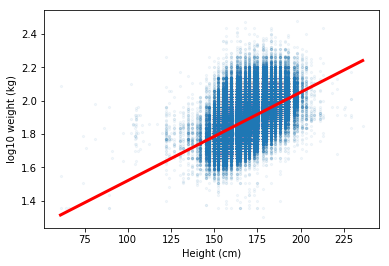

In [7]:
plt.plot(xs, y_hat, color = 'r', lw = 3)
plt.scatter(brf.htm3, log_weight, alpha=0.05, s = 5)
plt.xlabel('Height (cm)')
plt.ylabel('log10 weight (kg)');

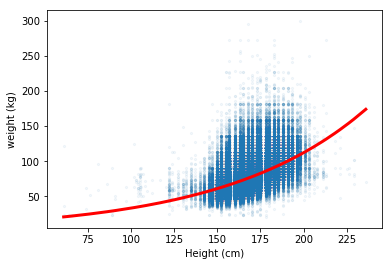

In [8]:
# transform weight back to present data in a more understandable way.
plt.plot(xs, 10**y_hat, color = 'r', lw = 3)
plt.scatter(brf.htm3, brf.wtkg2, alpha=0.05, s = 5)
plt.xlabel('Height (cm)')
plt.ylabel('weight (kg)');

In [9]:
res = thinkstats2.Residuals(brf.htm3, log_weight, inter, slope)

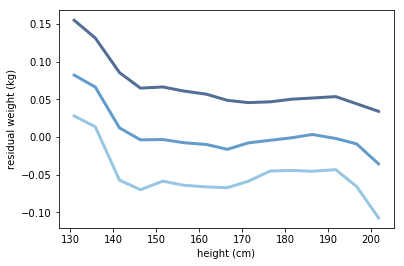

In [10]:
brf['residual'] = res

bins = np.arange(130, 210, 5)
indices = np.digitize(brf.htm3, bins)
groups = brf.groupby(indices)

means = [group.htm3.mean() for i, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.residual) for i, group in groups][1:-1]

thinkplot.PrePlot(3)
for percent in [75, 50, 25]:
    ys = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(means, ys, label=label)
    
thinkplot.Config(xlabel='height (cm)', ylabel='residual weight (kg)', legend=False)

In [11]:
thinkstats2.Var??

In [12]:
R_sq = thinkstats2.CoefDetermination(log_weight, res)
R_sq

0.28521743520658061

In [13]:
print('RMSE w/ Pred: ', np.std(res), 'RMSE w/o Pred: ', np.std(log_weight))

RMSE w/ Pred:  0.0871282957835 RMSE w/o Pred:  0.10305575376229134


In [14]:
1 - np.std(res) / np.std(log_weight)

0.1545518556447858

In [15]:
estimates = [thinkstats2.ResampleRows(brf).htm3.mean() for i in range(10)]

estimatesW = [thinkstats2.ResampleRowsWeighted(brf, column='finalwt').htm3.mean() for i in range(10)]

In [16]:
mean = thinkstats2.Mean(estimates)
stderr = thinkstats2.Std(estimates)
cdf = thinkstats2.Cdf(estimates)
ci = cdf.ConfidenceInterval(90)
print(mean, stderr, ci)
meanW = thinkstats2.Mean(estimatesW)
stderrW = thinkstats2.Std(estimatesW)
cdfW = thinkstats2.Cdf(estimatesW)
ciW = cdfW.ConfidenceInterval(90)
print(meanW, stderrW, ciW)

169.006018022 0.009601943829945324 (168.99194505329373, 169.02120868245012)
170.538859871 0.010897956070769479 (170.51792607792234, 170.55745205635614)


> The effect is small but non-negligible, but the difference in mean height is larger than the standard error, which implies it is not due to chance.

### Glossary

**linear fit:** a line intended to model the relationship between variables.

**least squares fit:** A model of a dataset that minimizes the sum of squares of the residuals.

**residual:** The deviation of an actual value from a model.

**goodness of fit:** A measure of how well a model fits data.

**coefficient of determination:** A statistic intended to quantify goodness of fit.

**sampling weight:** A value associated with an observation in a sample that indicates what part of the population it represents.